# CPI index analysis - multiplicative model

This notebook tests a multiplicative model to separate the trend, seasonality and erratic component of the  time series

**Author:** Joana Simões, joanasimoes@student.dei.uc.pt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.signal as scs
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as st
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from utils import * 

In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

## Introduction

This notebook presents an analysis of the CPI Index from Norway from 1990 until the most recent update (August, 2022). 

NOTE: Throughout the analysis, a significance level of 95% was chosen for all the tests developed.

## Read data

In [3]:
df = pd.read_csv(os.path.join('..', 'CPITimeSeries', 'time_series_data.csv'), index_col='Date')

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
# select data from 1990 until now
df = df.loc[df.index >= '1990-01-01']

In [6]:
df

,Brazil,France,Bulgaria,Honduras,Colombia,Canada,Côte d'Ivoire,Finland,Germany,"China, P.R.: Mainland",...,Uruguay,"Venezuela, Rep. Bolivariana de",Syrian Arab Rep.,"Yemen, Rep. of","Timor-Leste, Dem. Rep. of",Trinidad and Tobago,Suriname,"Tajikistan, Rep. of","Uzbekistan, Rep. of",Thailand
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,0.005411,66.42,NaN,NaN,5.967753,76.7,NaN,64.40331,62.22656,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,0.009508,66.56,NaN,NaN,6.191108,77.2,NaN,64.68612,62.48747,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-01,0.017343,66.72,NaN,NaN,6.372583,77.5,NaN,64.94263,62.48747,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,0.020034,67.09,NaN,NaN,6.547079,77.5,NaN,65.30437,62.61792,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-01,0.021555,67.19,NaN,NaN,6.679696,77.9,NaN,65.52799,62.74837,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,6382.880000,110.97,8331.527222,384.2,117.708900,149.8,114.7,111.30000,116.20000,102.9,...,251.65,NaN,NaN,NaN,NaN,115.9,NaN,NaN,121.371083,105.15
2022-05-01,6412.880000,111.72,8432.652791,387.6,118.703200,151.9,114.9,112.76000,117.30000,102.7,...,252.82,NaN,NaN,NaN,NaN,115.9,NaN,NaN,122.621205,106.62
2022-06-01,6455.850000,112.55,8506.693988,392.7,119.305300,152.9,117.4,113.57000,117.40000,102.7,...,254.30,NaN,NaN,NaN,NaN,116.2,NaN,NaN,123.773844,107.58


## Select the data from Norway

In [7]:
country = 'Norway'

## Time series overview 

In [8]:
df.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', name='Date', length=392, freq=None)

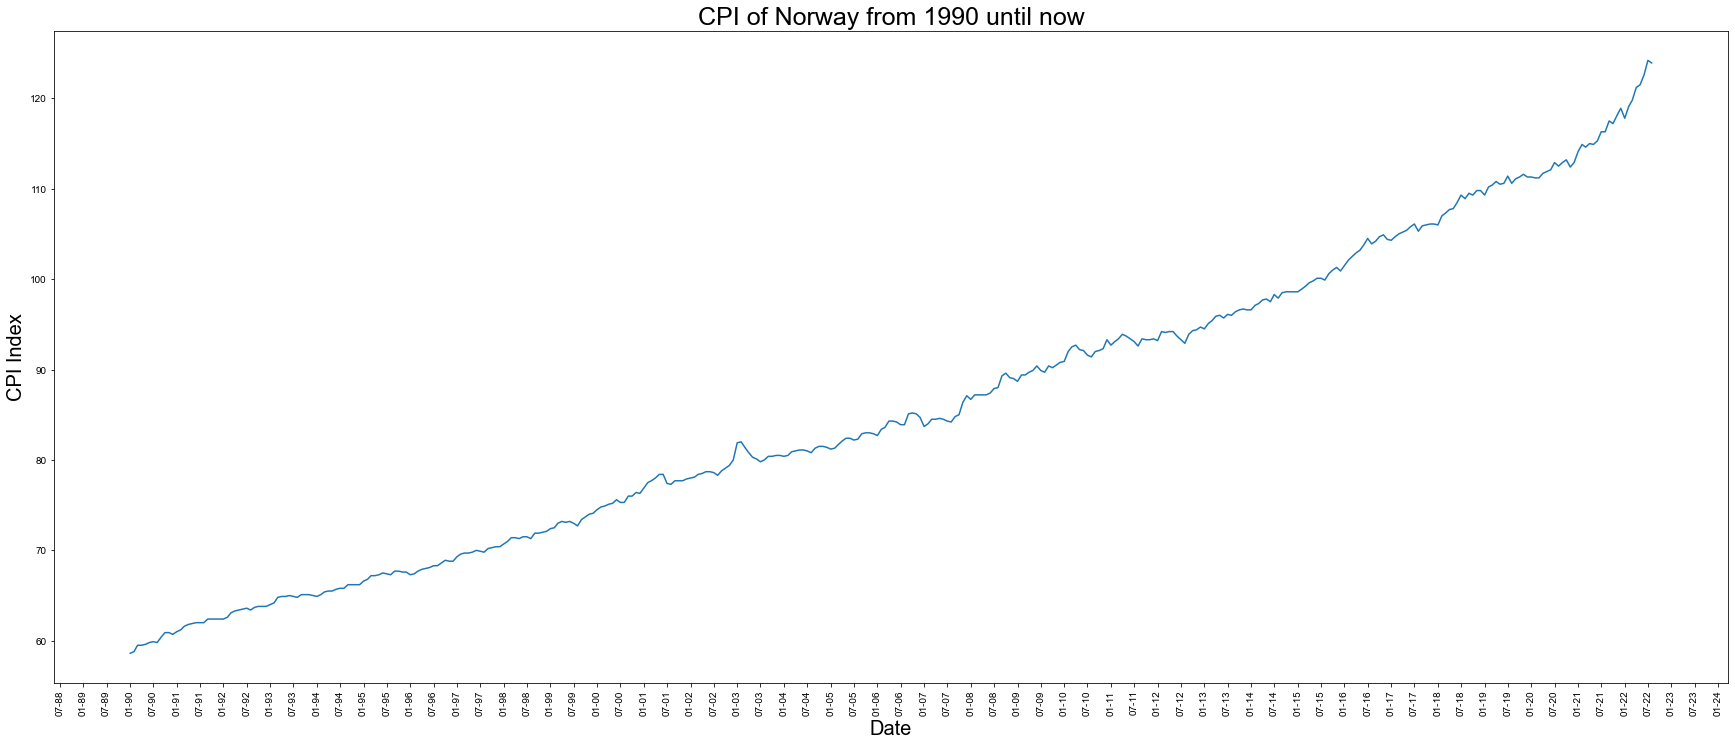

In [9]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.set(font_scale=1.5, style="whitegrid")
plt.plot(df.index, df[country])

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
plt.title(f'CPI of {country} from 1990 until now', fontdict=dict(size=25))
plt.show()


In a first analysis of the time series (TS), it's clearly seen a increasing trend of the CPI values over time. On a closer look, the TS appears to have a repetition (seasonality) every 6 months. With the increasing trend and seasonality every 6-months, it can be concluded that the original TS is not stationary. Therefore, it should be transformed to become stationary in order to apply forecasting models.

From the TS, it can also be concluded that there is and rapid increasing in the last 2-3 years, which will impact the final results as this exponential increasing is just the final part of the TS

## Divide the time series into train and test

In [10]:
train_ratio = 0.8
split_index = int(len(df) * train_ratio)

# Split the time series data
train_data = df[:split_index]
test_data = df[split_index:]
months_dates = months = np.arange(len(df))
months = months_dates[:split_index]
months_test = months_dates[split_index:]

In [11]:
ts = train_data[country]
ts_test = test_data[country]

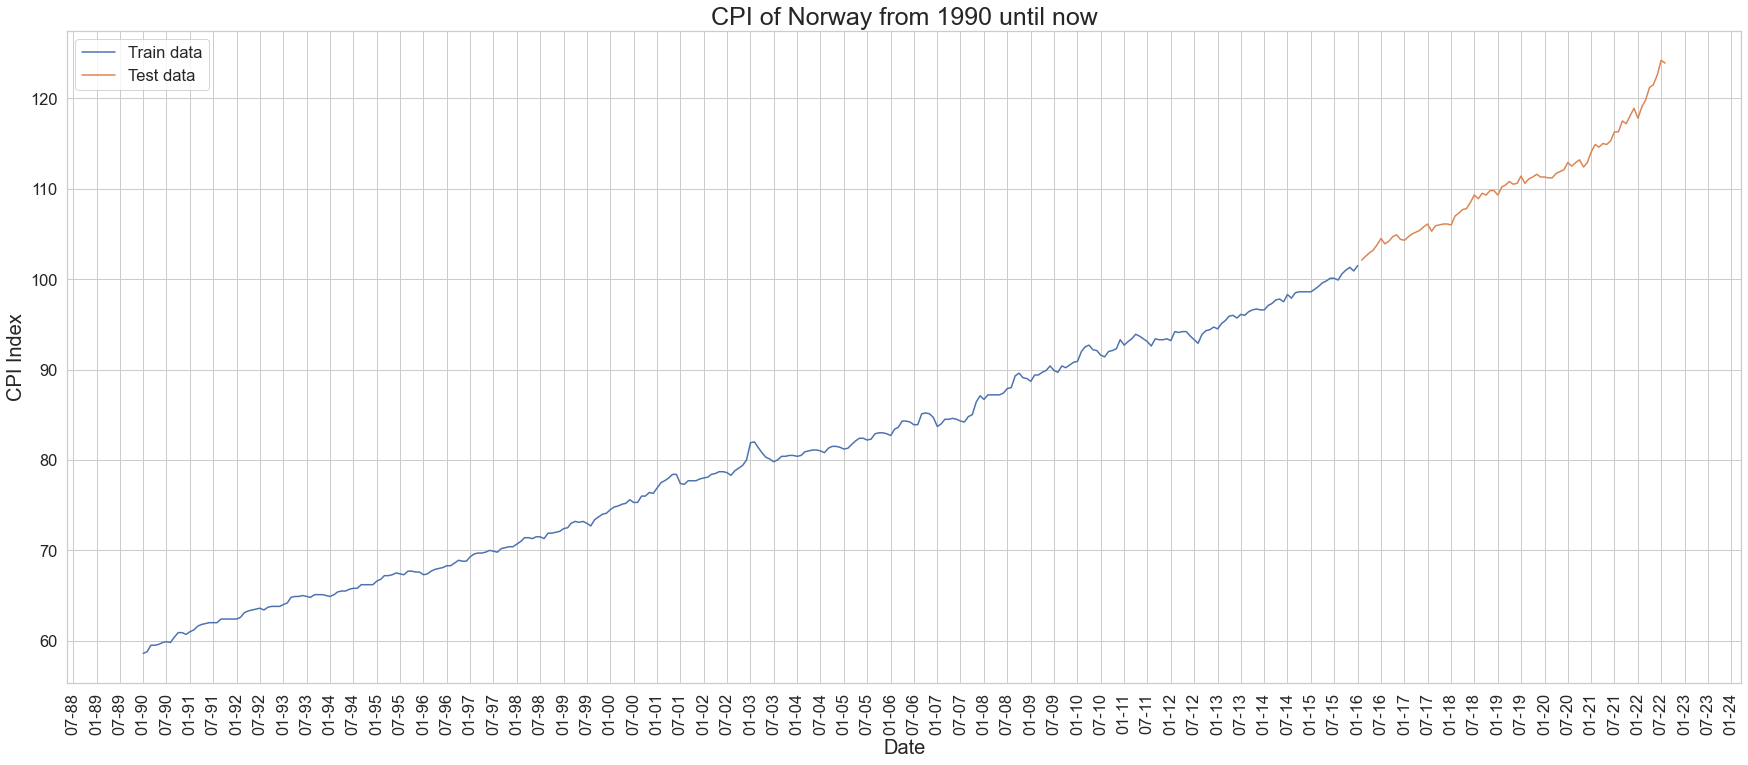

In [12]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.set(font_scale=1.5, style="whitegrid")
plt.plot(ts.index, ts, label='Train data')
plt.plot(ts_test.index, ts_test, label='Test data')
plt.legend()
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
plt.title(f'CPI of {country} from 1990 until now', fontdict=dict(size=25))
plt.show()

## Check if it has missing values

In [13]:
print('Null values [Train data] -', ts.isnull().any())
print('Null values [Test data] -', ts_test.isnull().any())

Null values [Train data] - False
Null values [Test data] - False


## First look at stationary by statistical test

The Dickey-Fuller (DF) unit root test is a statistical test that assesses the existence of this unit root. The test null and alternative hypotheses are:
  - H0 (𝜙 = 1): a unit root is present in a time series sample (non-stationary TS) 
  - H1 (𝜙 < 1): a unit root is not present in a time series sample (stationary TS)

In [14]:
adf_test(ts)

ADF Statistic: 0.998852
p-value: 0.994254
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


Since the p-value from the DF test is higher than 0.05, the null hypothesis cannot be rejected, meaning that the original TS is non-stationary.

## Decomposition models

As the magnitude of the time series (TS) does not seem to change over time, it will be used an additive model

    x(n) = tr(n) + sn(n) + e(n)

 tr - trend component
 sn - seasonal component
 e = erratic component

## Check trend

In [15]:
T = 12 # period

In [16]:
## trend
coefs_1d = np.polyfit(months, np.array(ts), deg=1)
values_1d = np.polyval(coefs_1d, months)
ts_1d = pd.Series(values_1d, index=ts.index, name='Linear Fit')

coefs_2d = np.polyfit(months, np.array(ts), deg=2)
values_2d = np.polyval(coefs_2d, months)
ts_2d = pd.Series(values_2d, index=ts.index, name='Quadratic Fit')

coefs_3d = np.polyfit(months, np.array(ts), deg=3)
values_3d = np.polyval(coefs_3d, months)
ts_3d = pd.Series(values_3d, index=ts.index, name='Cubic Fit')

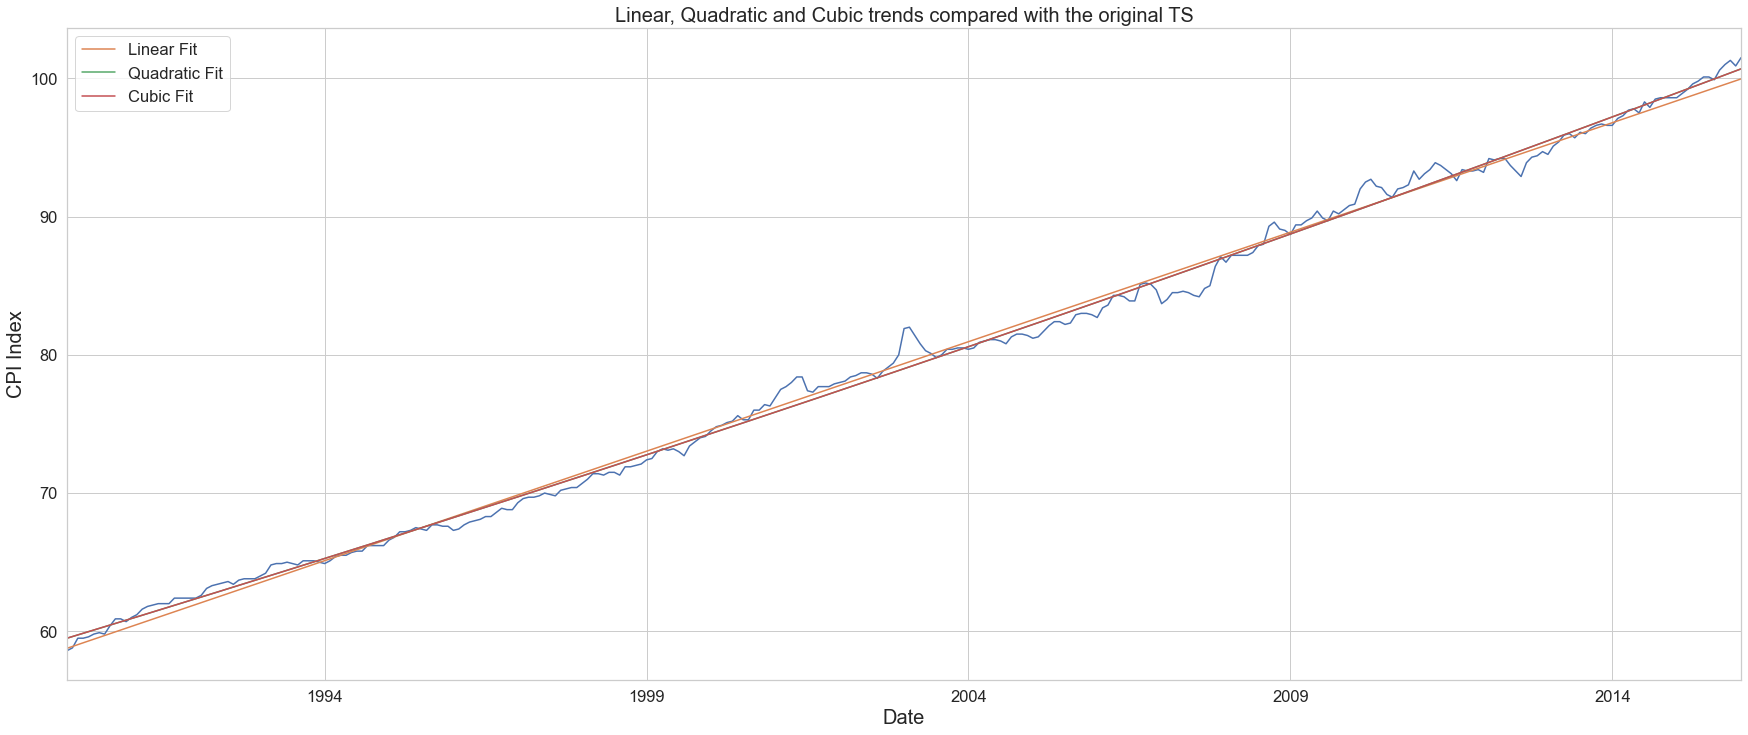

In [17]:
ax = ts.plot(figsize=(30, 12))
ts_1d.plot(ax=ax, legend=True)
ts_2d.plot(ax=ax, legend=True)
ts_3d.plot(ax=ax, legend=True)
ax.set_xlabel('Date', fontdict=dict(size=20))
ax.set_ylabel('CPI Index', fontdict=dict(size=20))
ax.set_title('Linear, Quadratic and Cubic trends compared with the original TS', fontdict=(dict(size=20)))
plt.show()

After analyzing the results of plotting the original time series (TS) against the linear, quadratic and cubic trends, it was observed that there isn't a great difference in them, so it was chosen the linear trend since it is simpler.

In [18]:
trend = ts_1d
trend_adjusted = ts / trend
trend_adjusted.name = 'Trend Adjusted'

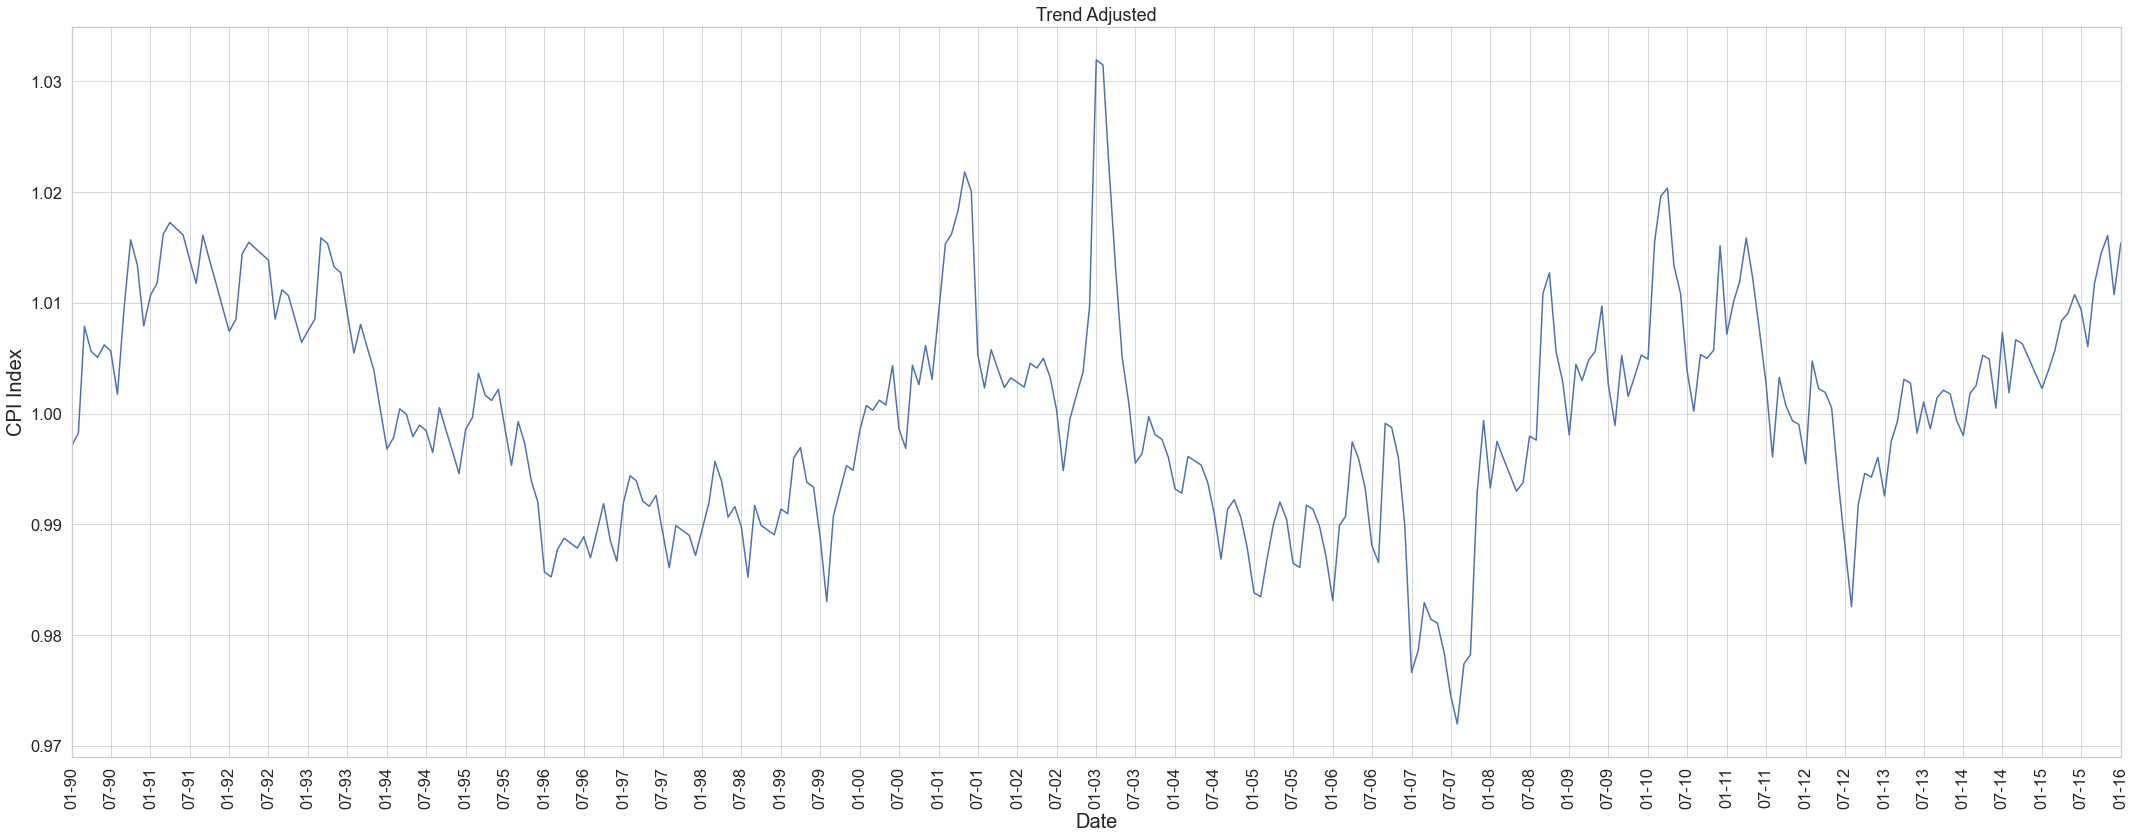

In [19]:
fig, axs = plt.subplots(1,figsize=(30, 12))

axs.plot(trend_adjusted.index, trend_adjusted)
axs.set_ylabel('CPI Index')
axs.set_title('Trend Adjusted TS')
date_form = DateFormatter("%m-%y")
axs.xaxis.set_major_formatter(date_form)
axs.grid(True)
axs.grid(which='minor', alpha=0.3)
axs.grid(which='major', alpha=0.8)
axs.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs.set_xlim(ts.index[0], ts.index[-1])
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
axs.set_title('Trend Adjusted')
plt.tight_layout()
plt.show()

After adjusting the TS to the trend, the seasonal patterns appear more clearly. Each 6-month interval contains a peak more or less in the middle. At the same time, it can be seen a bigger pattern that repeat each +-7 years.

## Seasonality

In [20]:
minor_ticks = np.linspace(0, 6, 61)

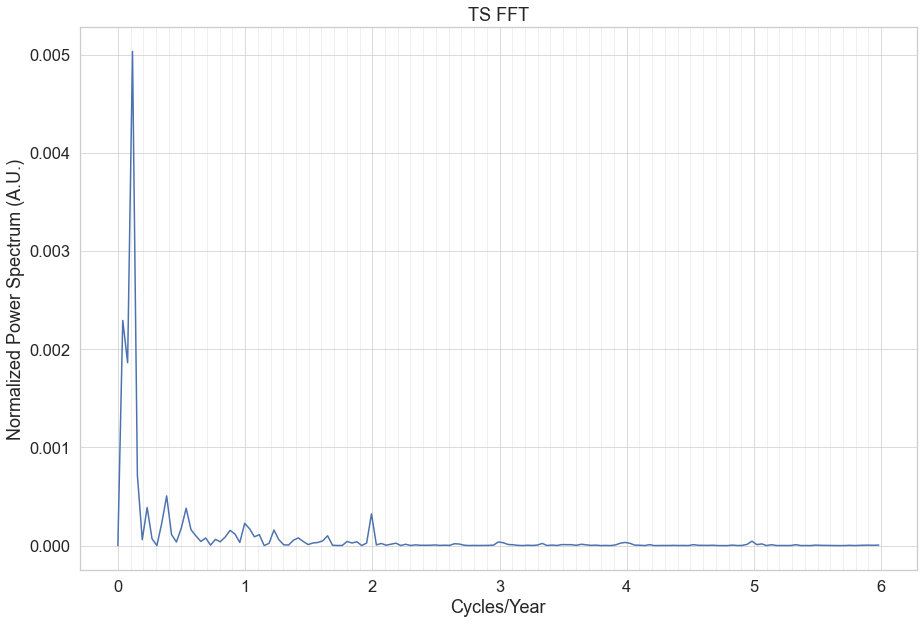

In [21]:
fTS=(np.abs(np.fft.rfft(trend_adjusted-trend_adjusted.mean()))**2/trend_adjusted.size)
sample_freq = 12 # 12 samples per year

f = np.fft.rfftfreq(trend_adjusted.size, d=1/sample_freq)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(f,fTS)
ax.set_xticks(minor_ticks, minor=10)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.7)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.title('TS FFT')
plt.show()

Analyzing the frequency distributions, it can confirm the previous seasonality patterns observed ever each 6 months and every 5 years, not the previous 7 years. However, it also appeared new patters every month and every 3 months and every 2 years.

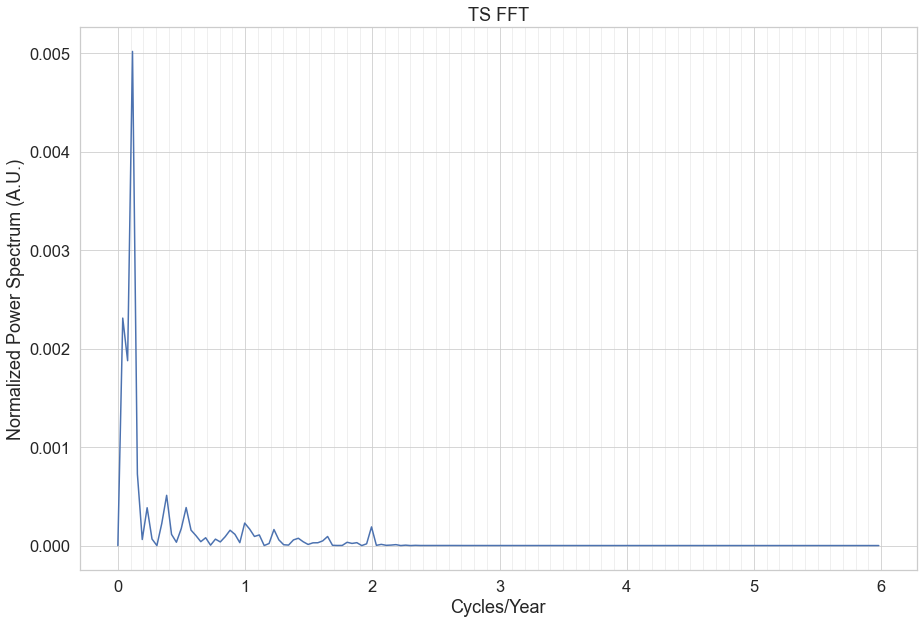

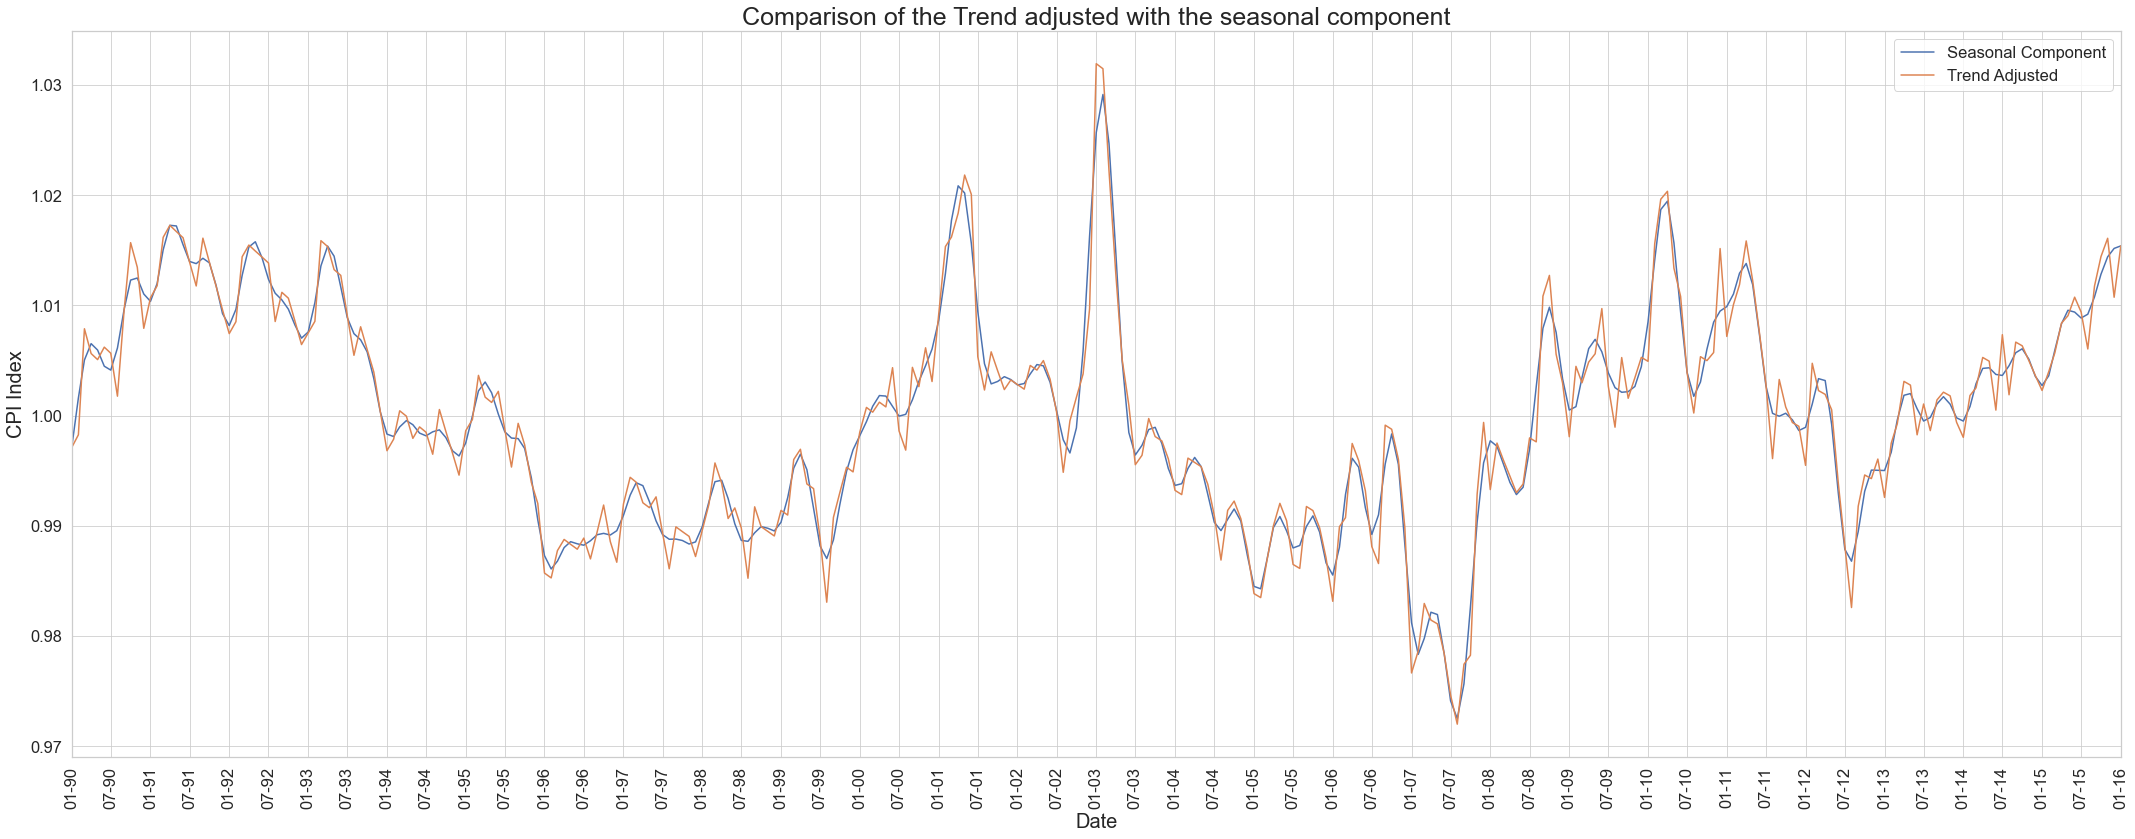

In [22]:
sos = scs.butter(N=5, fs=sample_freq, Wn=[2.2], btype='lowpass', output='sos')
seasonal = scs.sosfiltfilt(sos, trend_adjusted)
#Lets look at the filter effect
fTS=(np.abs(np.fft.rfft(seasonal-np.mean(seasonal)))**2/trend_adjusted.size)# Mean was subtracted because 

f = np.fft.rfftfreq(trend_adjusted.size, d=1/sample_freq)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(f,fTS)
ax.set_xticks(minor_ticks, minor=10)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.8)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.title('TS FFT')
plt.show()


seasonal_ts = pd.Series(data=seasonal, index=ts.index, name='Seasonal Component')

fig, ax = plt.subplots(1, figsize=(30, 12))
ax.plot(seasonal_ts.index, seasonal_ts, label='Seasonal Component')
ax.plot(trend_adjusted.index, trend_adjusted, label='Trend Adjusted')
plt.legend()
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.8)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
ax.set_xlim(seasonal_ts.index[0], seasonal_ts.index[-1])
plt.xlabel('Date', fontdict=(dict(size=20)))
plt.ylabel('CPI Index', fontdict=(dict(size=20)))
plt.title('Comparison of the Trend adjusted with the seasonal component', fontdict=(dict(size=25)))
plt.tight_layout()
plt.show()


In [23]:
# remove seasonality
trend_seasonal_adjusted = trend_adjusted / seasonal_ts
trend_seasonal_adjusted.name = 'Trend and seasonality adjusted'

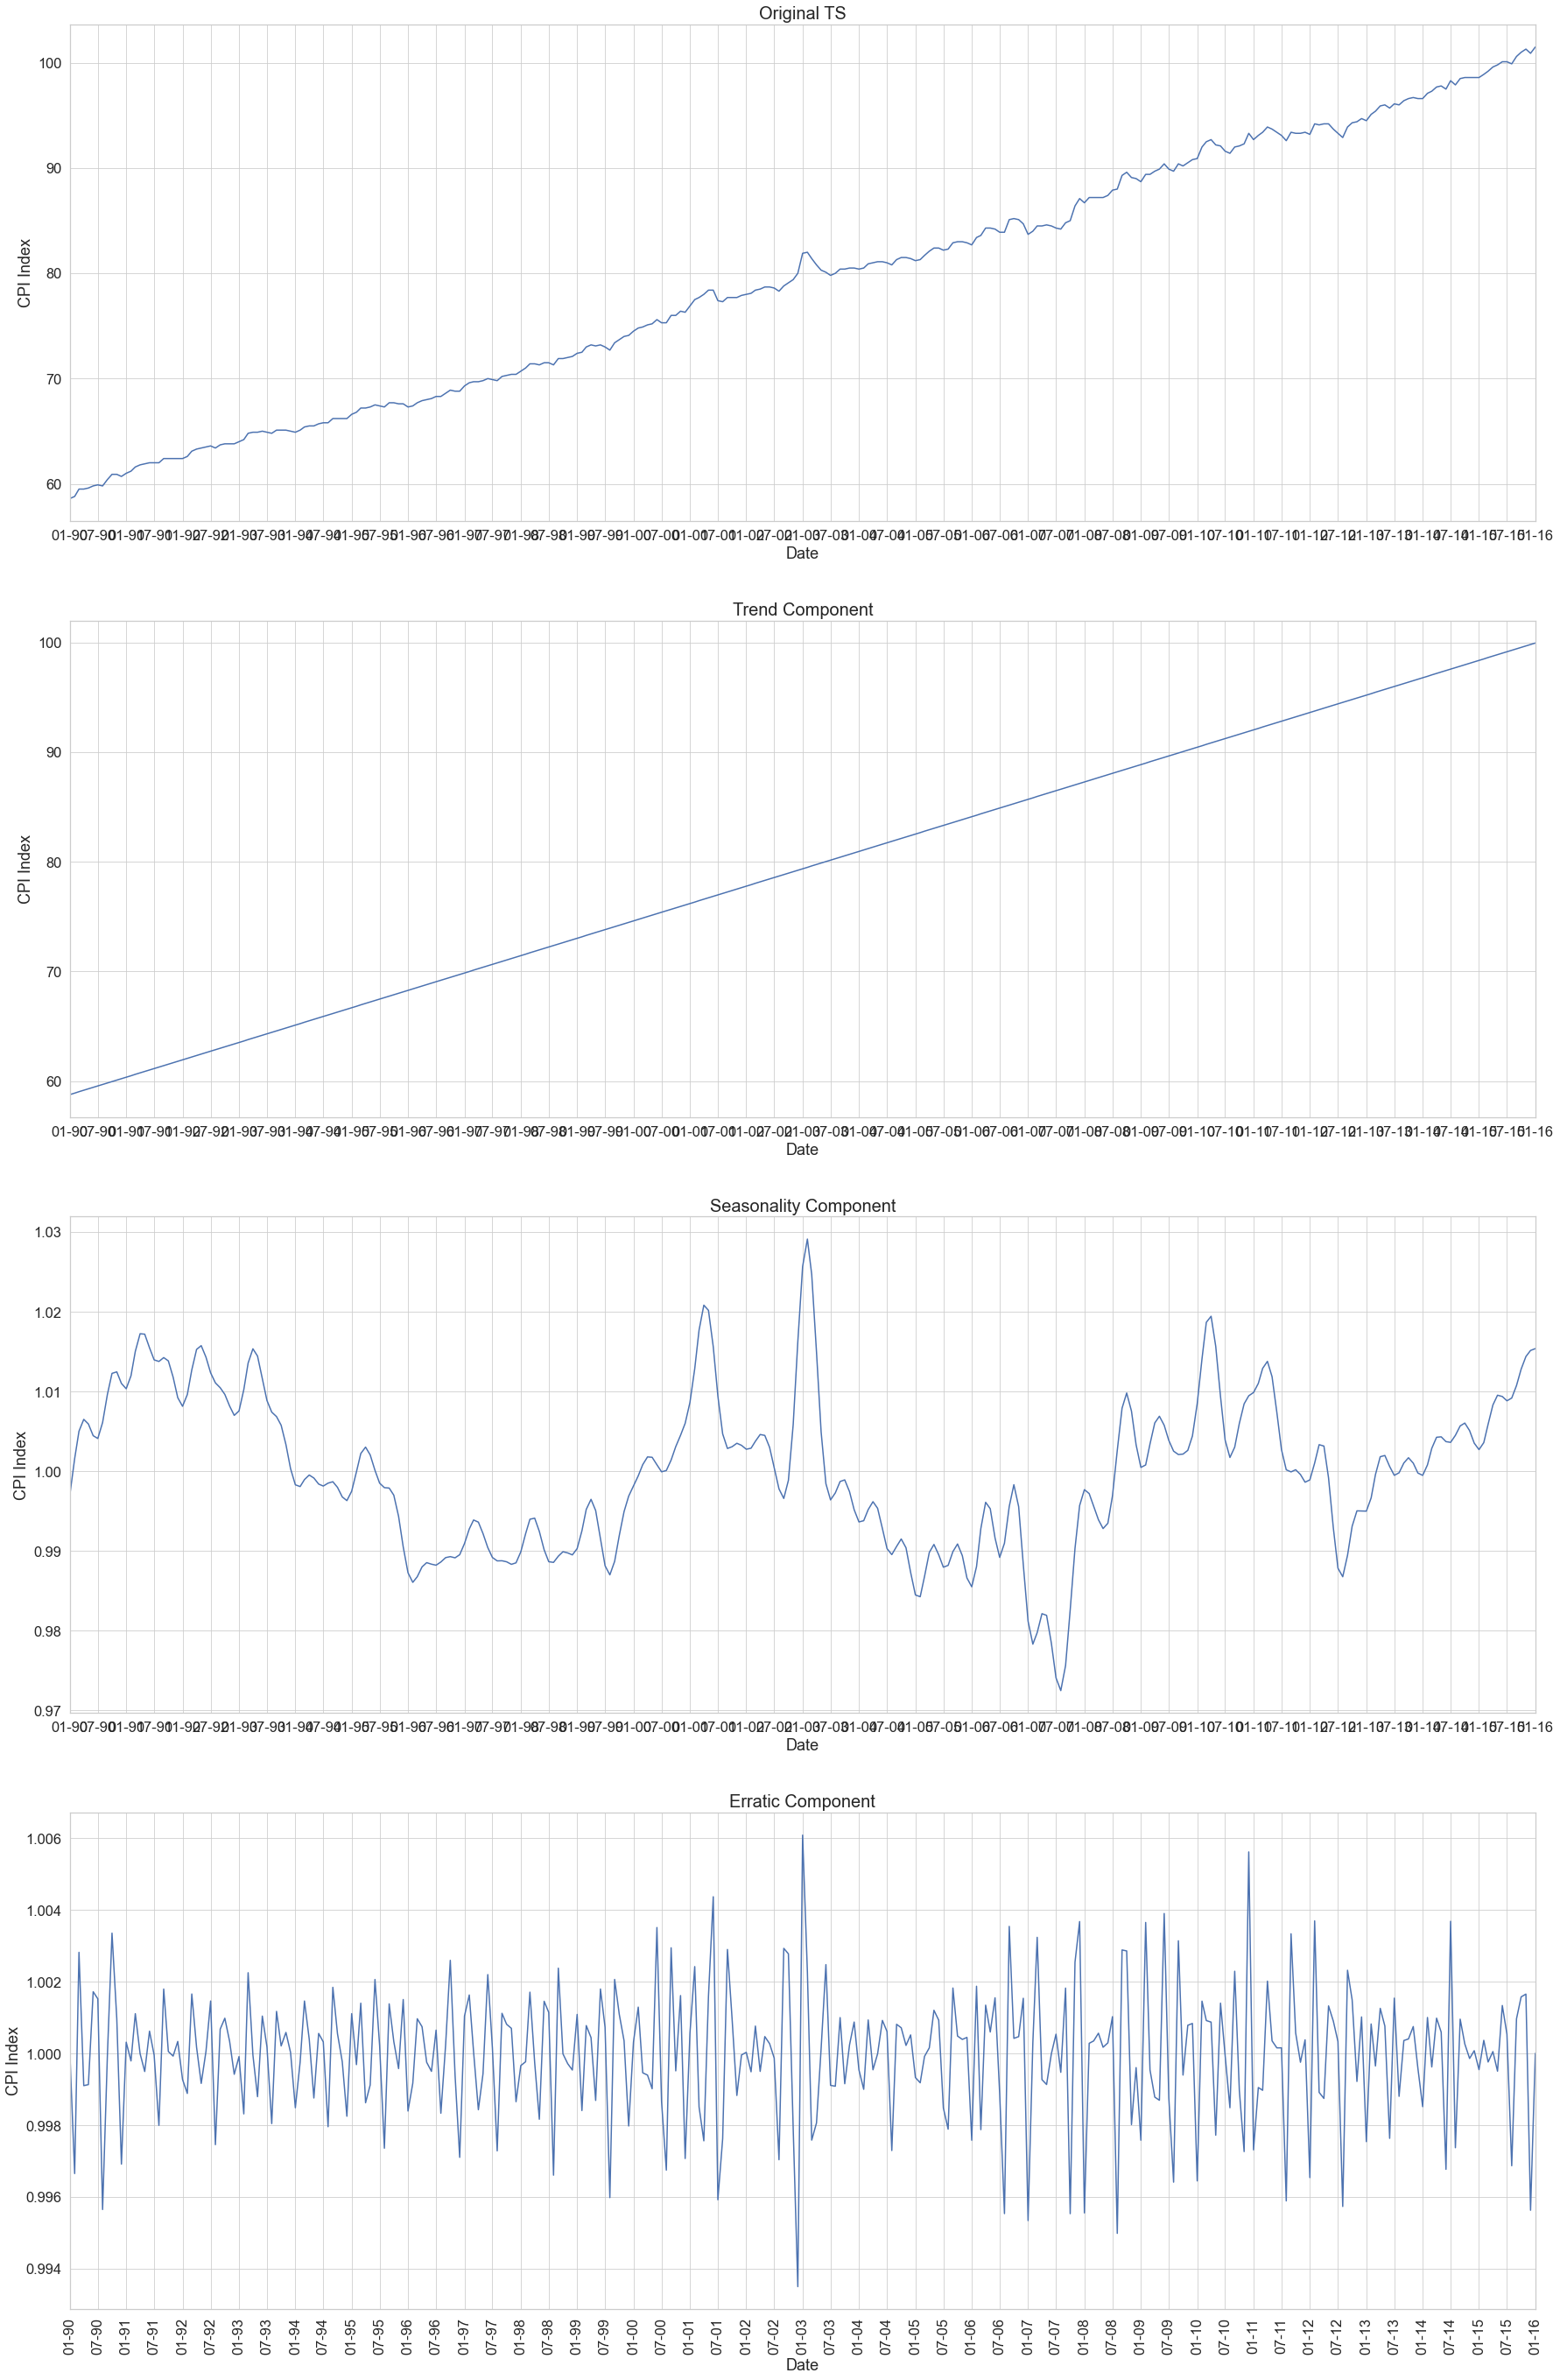

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(30, 12*4))
axs[0].plot(ts.index, ts)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('CPI Index')
axs[0].set_title('Original TS', fontdict=dict(size=20))
date_form = DateFormatter("%m-%y")
axs[0].xaxis.set_major_formatter(date_form)
axs[0].grid(which='minor', alpha=0.3)
axs[0].grid(which='major', alpha=0.8)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
axs[0].set_xlim(ts.index[0], ts.index[-1])

axs[1].plot(trend.index, trend)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('CPI Index')
axs[1].set_title('Trend Component', fontdict=dict(size=20))
date_form = DateFormatter("%m-%y")
axs[1].xaxis.set_major_formatter(date_form)
axs[1].grid(which='minor', alpha=0.3)
axs[1].grid(which='major', alpha=0.8)
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
axs[1].set_xlim(trend.index[0], trend.index[-1])

axs[2].plot(seasonal_ts.index, seasonal_ts)
axs[2].set_xlabel('Date')
axs[2].set_ylabel('CPI Index')
axs[2].set_title('Seasonality Component', fontdict=dict(size=20))
date_form = DateFormatter("%m-%y")
axs[2].xaxis.set_major_formatter(date_form)
axs[2].grid(which='minor', alpha=0.3)
axs[2].grid(which='major', alpha=0.8)
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
axs[2].set_xlim(seasonal_ts.index[0], seasonal_ts.index[-1])

axs[3].plot(trend_seasonal_adjusted.index, trend_seasonal_adjusted)
axs[3].set_xlabel('Date')
axs[3].set_ylabel('CPI Index')
axs[3].set_title('Erratic Component', fontdict=dict(size=20))
date_form = DateFormatter("%m-%y")
axs[3].xaxis.set_major_formatter(date_form)
axs[3].grid(which='minor', alpha=0.3)
axs[3].grid(which='major', alpha=0.8)
axs[3].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
axs[3].set_xlim(trend_seasonal_adjusted.index[0], trend_seasonal_adjusted.index[-1])
plt.show()

## Statistical test to check stationary

### Trend and seasonal adjusted by model-fitting and filtering

In [25]:
adf_test(trend_seasonal_adjusted)

ADF Statistic: -12.471060
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


Based on the ADF test, given the p-value of 0.0, the transformed TS is stationary.
As the ADF statistic presents a closer value to the critical points than the additive model, the second was selected to continue with the experiment.